In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tempfile
import requests
import zipfile
import datetime

In [26]:
print(f"Generated on {datetime.datetime.utcnow()} UTC")

Generated on 2021-07-21 07:44:07.901052 UTC


In [4]:
df = pd.read_csv("https://covid.ourworldindata.org/data/owid-covid-data.csv")
df.index = pd.to_datetime(df.date)
df["death_ratio"] = df.new_deaths_smoothed_per_million / df.new_cases_smoothed_per_million

In [5]:
fr_dep_df = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/5c4e1452-3850-4b59-b11c-3dd51d7fb8b5")
fr_dep_df.index = pd.to_datetime(fr_dep_df.date)

fr_df = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/f335f9ea-86e3-4ffa-9684-93c009d5e617")
fr_df.index = pd.to_datetime(fr_df.date)

/Users/pagessin/default_jupyter_kernel/venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [34]:
r = requests.get("https://www.covid19.admin.ch/api/data/context")
url = r.json()["sources"]["zip"]["csv"]
print(url)

from pathlib import Path
with tempfile.TemporaryD
# dl = Path.cwd() / "dl.zip"
# print(dl.resolve())
with requests.get(url, stream=True) as r:
    with dl.open("wb") as fh:
        r.raise_for_status()
        for chunk in r.iter_content(chunk_size=8192): 
            fh.write(chunk)
    
with zipfile.ZipFile(fh.name) as z:
    with z.open("data/COVID19Cases_geoRegion.csv") as fh:
        ch_df = pd.read_csv(fh)
            
ch_df.index = pd.to_datetime(ch_df.datum)
    
# ch_df = pd.read_csv("https://www.covid19.admin.ch/api/data/20210719-wpjcvnzf/downloads/sources-csv.zip")
# ch_df

https://www.covid19.admin.ch/api/data/20210721-g7n1dbye/downloads/sources-csv.zip
/Users/pagessin/dev/covid19/dl.zip


In [22]:
df.columns

Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'new_tests', 'total_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'new_vaccinations',
       'new_vaccinations_smoothed', 'total_vaccinations_per_hun

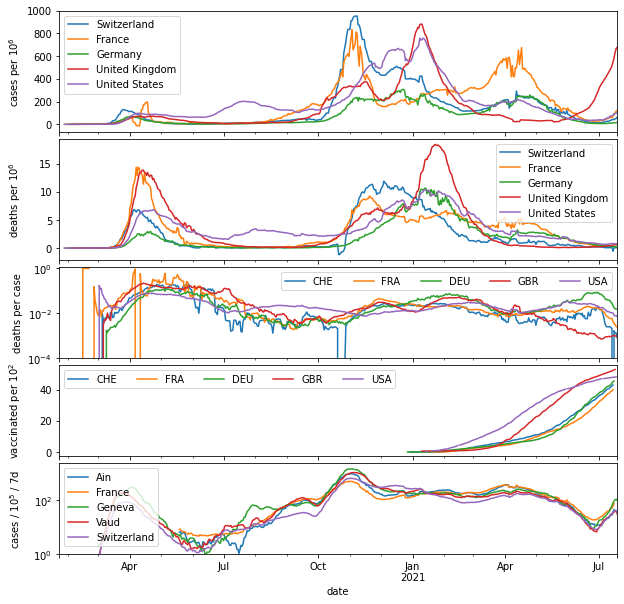

In [27]:
fig, axs = plt.subplots(5, 1, figsize=(10, 10), gridspec_kw={"height_ratios": [1, 1, 0.75, 0.75, 0.75], "hspace": 0.07}, sharex=True)
ax1, ax2, ax3, ax4, ax5 = axs
for country in (
    "CHE", 
    "FRA", 
    "DEU", 
    "GBR", 
    "USA",
):
    cdf = df[df.iso_code == country]
    
    name = cdf.location[0]
    cdf.plot(y="new_cases_smoothed_per_million", ax=ax1, label=name)
    cdf.plot(y="new_deaths_smoothed_per_million", ax=ax2, label=name)
   
    cdf.plot(y="death_ratio", ax=ax3, label=country)
    
    cdf.plot(y="people_fully_vaccinated_per_hundred", ax=ax4, label=f"{country}")
#     cdf.plot("date", "people_vaccinated_per_hundred", ax=ax3, ls="--", c=ax3.get_lines()[-1].get_color(), label=f"total")


fr_dep_df[fr_dep_df.lib_dep == "Ain"].plot(y="tx_incid", ax=ax5, label="Ain")
fr_df.plot(y="tx_incid", ax=ax5, label="France")
ch_df[ch_df.geoRegion == "GE"].plot(y="inzsum7d", ax=ax5, label="Geneva")
ch_df[ch_df.geoRegion == "VD"].plot(y="inzsum7d", ax=ax5, label="Vaud")
ch_df[ch_df.geoRegion == "CH"].plot(y="inzsum7d", ax=ax5, label="Switzerland")
ax5.set_yscale("log")
ax5.set_ylim(bottom=1)

ax5.set_xlabel("date")
ax5.set_ylabel("cases / $10^5$ / 7d")

ax4.legend(ncol=5)
ax3.legend(ncol=5)

ax3.set_ylim(bottom=1e-4)
ax3.set_yscale("log")

ax1.set_ylabel("cases per $10^6$")
ax2.set_ylabel("deaths per $10^6$")
ax3.set_ylabel("deaths per case")
ax4.set_ylabel("vaccinated per $10^2$")

fig.align_ylabels()
# fig.tight_layout()
plt.show()

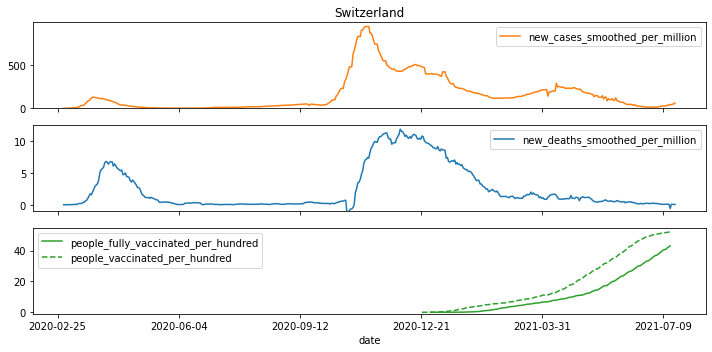

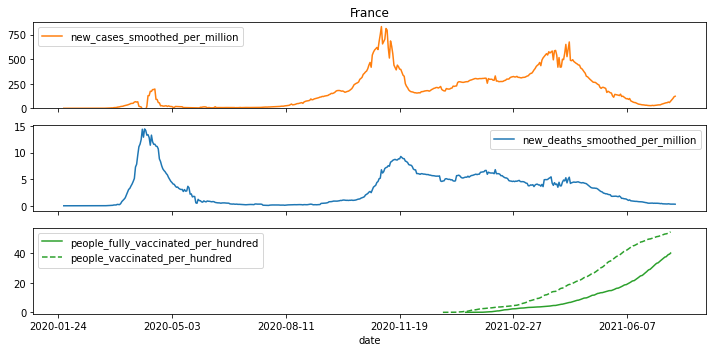

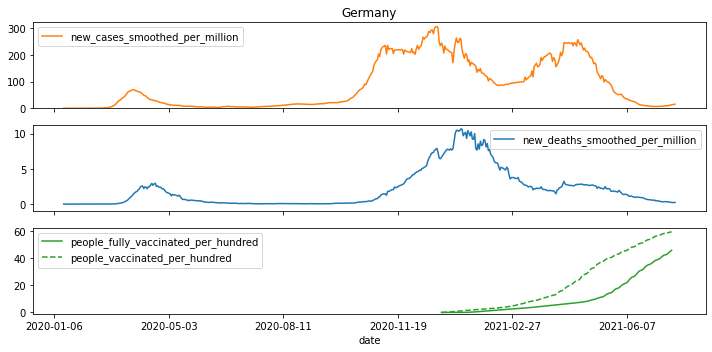

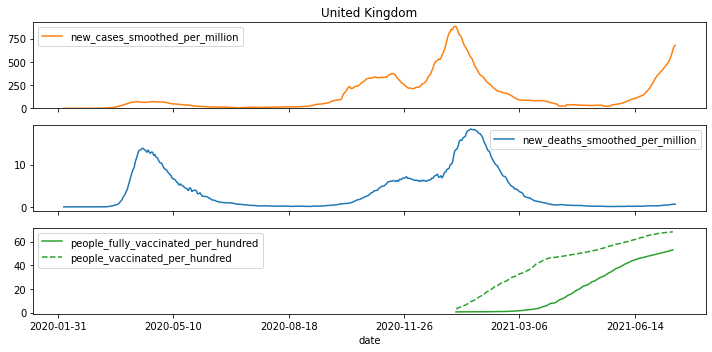

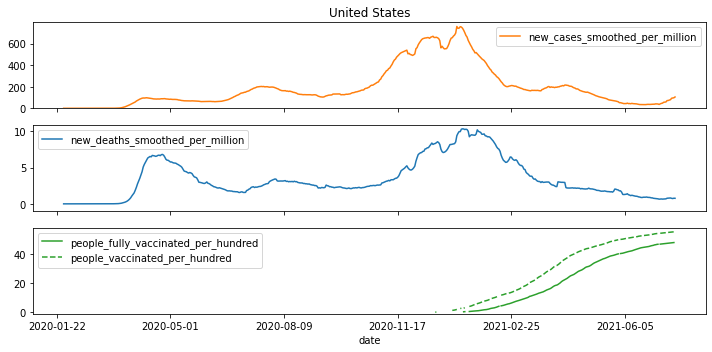

In [9]:
for country in (
    "CHE", 
    "FRA", 
    "DEU", 
    "GBR", 
    "USA",
):
    cdf = df[df.iso_code == country]
    fig, axs = plt.subplots(3, 1, figsize=(10, 5), sharex=True)
    ax1, ax2, ax3 = axs
    cdf.plot("date", "new_cases_smoothed_per_million", ax=ax1, c="tab:orange")
    cdf.plot("date", "new_deaths_smoothed_per_million", ax=ax2, c="tab:blue")
    cdf.plot("date", "people_fully_vaccinated_per_hundred", ax=ax3, c="tab:green")
    cdf.plot("date", "people_vaccinated_per_hundred", ax=ax3, c="tab:green", ls="--")
    
    for ax in axs:
        ax.set_ylim(bottom=-1)

    ax1.set_title(cdf.location[0])
    fig.tight_layout()
    plt.show()

Text(0, 0.5, 'incidence / $10^5$ inhabitants')

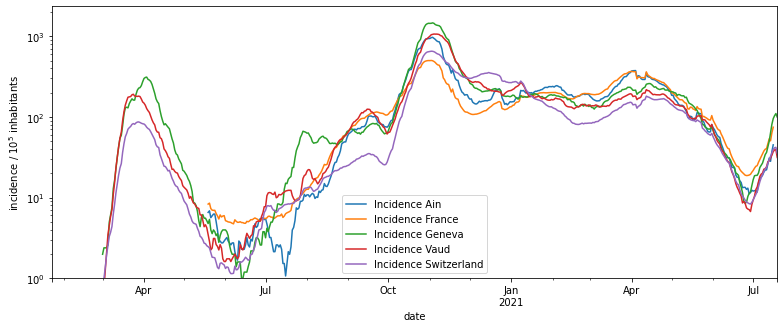

In [10]:
fig, ax = plt.subplots(figsize=(13,5))
fr_dep_df[fr_dep_df.lib_dep == "Ain"].plot(y="tx_incid", ax=ax, label="Incidence Ain")
fr_df.plot(y="tx_incid", ax=ax, label="Incidence France")
ch_df[ch_df.geoRegion == "GE"].plot(y="inzsum7d", ax=ax, label="Incidence Geneva")
ch_df[ch_df.geoRegion == "VD"].plot(y="inzsum7d", ax=ax, label="Incidence Vaud")
ch_df[ch_df.geoRegion == "CH"].plot(y="inzsum7d", ax=ax, label="Incidence Switzerland")
ax.set_yscale("log")
ax.set_ylim(bottom=1)
ax.set_xlabel("date")
ax.set_ylabel("incidence / $10^5$ inhabitants")